*This one uses kernel from the Starter.ipynb btw*

In [6]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
FULL_train = dd.read_csv('../#Data/train.csv')

In [8]:
FULL_test = dd.read_csv('../#Data/test.csv')

In [7]:
FULL_town_state = dd.read_csv('../#Data/town_state.csv')

In [8]:
FULL_town_state.head()

,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


In [9]:
FULL_train_town_state = FULL_town_state.merge(FULL_train)

In [10]:
SUM_demand_by_town = FULL_train_town_state.groupby('Town')['Demanda_uni_equil'].sum().compute()

In [11]:
SUM_demand_by_town.describe()

count    2.570000e+02
mean     2.085298e+06
std      1.387163e+06
min      7.206400e+04
25%      1.094138e+06
50%      1.884763e+06
75%      2.920998e+06
max      1.001191e+07
Name: Demanda_uni_equil, dtype: float64

In [12]:
SUM_demand_by_town.sort_values(ascending=False, inplace=True)

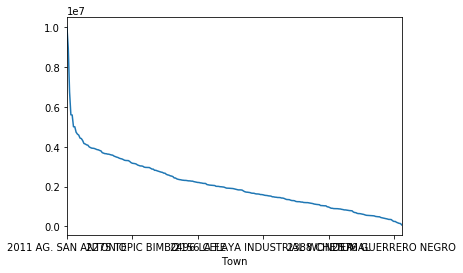

In [13]:
SUM_demand_by_town.plot()

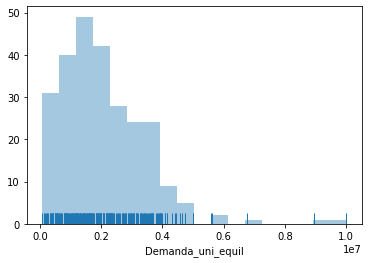

In [14]:
sns.distplot(SUM_demand_by_town, rug=True, kde=False)

In [15]:
SUM_demand_by_town_by_week = FULL_train_town_state.groupby(['Town', 'Semana'])['Demanda_uni_equil'].sum().compute()

In [16]:
SUM_demand_by_town_by_week.head()

Town                   Semana
2001 AG. ATIZAPAN      3         674742
2002 AG. AZCAPOTZALCO  3         461019
2003 AG. COACALCO      3         452187
2004 AG. CUAUTITLAN    3         330418
2007 AG. LA VILLA      3         608572
Name: Demanda_uni_equil, dtype: int64

In [17]:
SUM_demand_by_town_by_week.describe()

count    1.799000e+03
mean     2.978997e+05
std      1.999868e+05
min      1.107000e+03
25%      1.517840e+05
50%      2.661310e+05
75%      4.117785e+05
max      1.535400e+06
Name: Demanda_uni_equil, dtype: float64

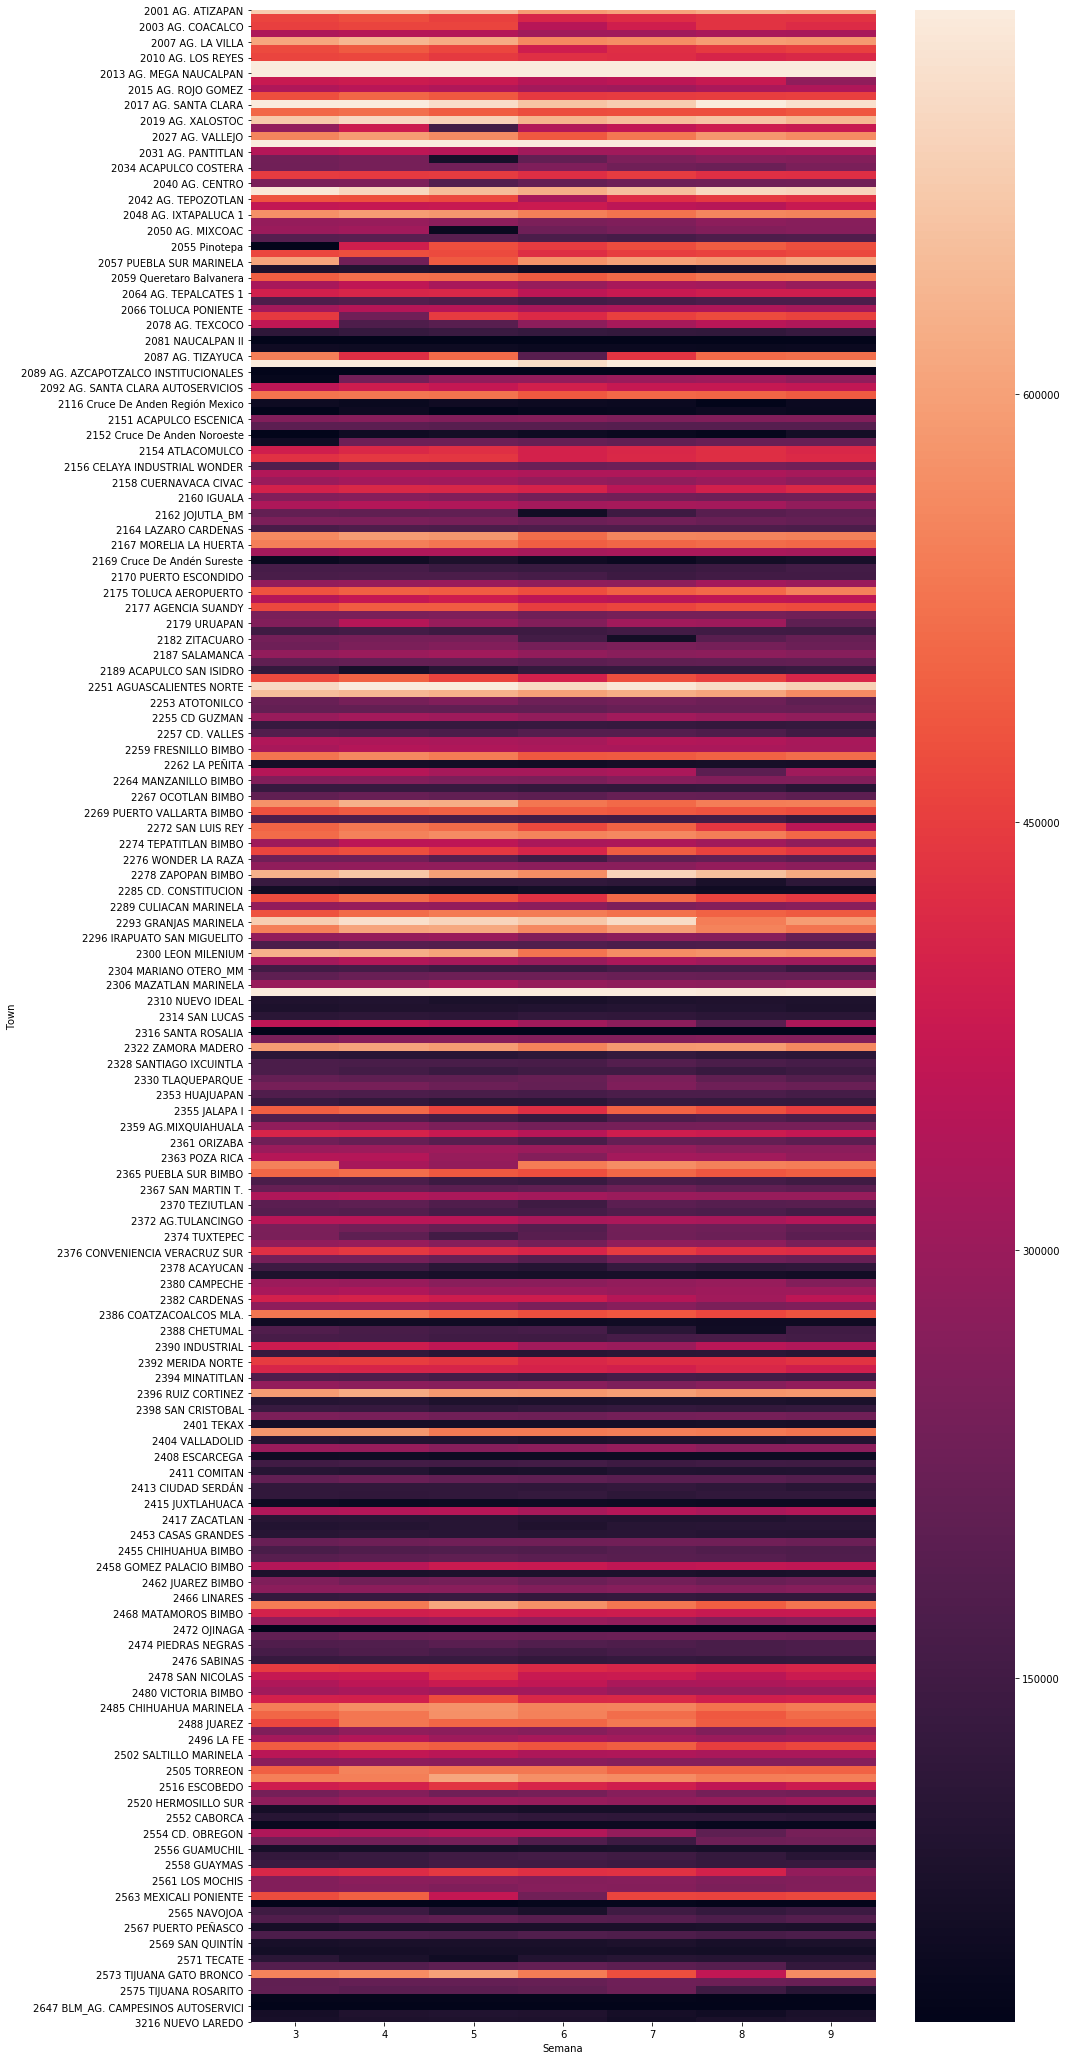

In [18]:
DF_hmap = pd.DataFrame(SUM_demand_by_town_by_week) #.reset_index()
DF_hmap.sort_values(by=['Semana', 'Demanda_uni_equil'], ascending=False, inplace=True)
DF_hmap

DF_hmap_pivot = DF_hmap.pivot_table(index="Town", columns="Semana", values="Demanda_uni_equil", dropna=True)
DF_hmap_pivot

plt.figure(figsize=(14,37))
hmap = sns.heatmap(data=DF_hmap_pivot, robust=True)

In [19]:
DF_hmap_pivot.loc['2573 TIJUANA GATO BRONCO']

Semana
3    550125
4    564190
5    600501
6    539333
7    474852
8    362894
9    564302
Name: 2573 TIJUANA GATO BRONCO, dtype: int64

In [20]:
DF_hmap_pivot.loc['2572 TIJUANA EL FLORIDO']

Semana
3    186410
4    184379
5    202724
6    212706
7    198407
8    187326
9    124350
Name: 2572 TIJUANA EL FLORIDO, dtype: int64

In [21]:
DF_hmap_pivot.loc['2563 MEXICALI PONIENTE']

Semana
3    470576
4    498749
5    369026
6    236081
7    459901
8    456738
9    466191
Name: 2563 MEXICALI PONIENTE, dtype: int64

As we can see, there's no ultimate 'golden weeks', and some weeks can be extremely unlucky for some towns, whle being extremely lucky for the others (we are speaking of up to +/- 50% variance in demand)

In [22]:
DF_hmap_pivot.loc['2563 MEXICALI PONIENTE'].describe()

count         7.000000
mean     422466.000000
std       91484.693481
min      236081.000000
25%      412882.000000
50%      459901.000000
75%      468383.500000
max      498749.000000
Name: 2563 MEXICALI PONIENTE, dtype: float64

Thus we'll use regression(maybe robust) for each client each product on a demo sample

Demo sample will be taken from one town i guess, taken by median value since the distribution is skewed

In [23]:
SUM_demand_by_town_by_week.median()

266131.0

In [24]:
DF_hmap_pivot.loc['2182 ZITACUARO'].describe()

count         7.000000
mean     192869.428571
std       64641.588648
min       65507.000000
25%      172763.500000
50%      216613.000000
75%      239330.000000
max      243779.000000
Name: 2182 ZITACUARO, dtype: float64

In [25]:
DF_hmap_pivot.loc['2182 ZITACUARO']

In [25]:
FULL_agencia_for_town = FULL_train_town_state[FULL_train_town_state['Town'] == '2182 ZITACUARO']

In [27]:
len(FULL_agencia_for_town)

254355

In [28]:
#AGG_agencia_for_town = FULL_agencia_for_town.groupby(['Agencia_ID'])['Demanda_uni_equil'].mean()
AGG_agencia_for_town = FULL_agencia_for_town.groupby(['Cliente_ID'])['Demanda_uni_equil'].sum()

In [29]:
len(AGG_agencia_for_town)

6104

In [30]:
#COUNT_agencia_by_town.head()
AGG_agencia_for_town

Dask Series Structure:
npartitions=1
    int64
      ...
Name: Demanda_uni_equil, dtype: int64
Dask Name: series-groupby-sum-agg, 411 tasks

In [31]:
LIGHT_agencia_for_town = AGG_agencia_for_town.compute()

In [32]:
LIGHT_agencia_for_town

Cliente_ID
11194      106
11247      324
11698      743
13498       64
13502        1
          ... 
4736676     13
4736871      7
4739602     26
4754621      6
6275215      8
Name: Demanda_uni_equil, Length: 6104, dtype: int64

In [33]:
AGG_agencia_client_for_town = FULL_agencia_for_town.groupby(['Agencia_ID','Cliente_ID', 'Producto_ID', 'Semana'])['Demanda_uni_equil'].sum().compute()

In [34]:
AGG_agencia_client_for_town

Agencia_ID  Cliente_ID  Producto_ID  Semana
2020        11194       1212         3          3
                        1230         3          1
                        1232         3          3
                        1240         3          5
                        43064        3          1
                                               ..
            9709447     35651        9          1
                        41843        9          3
            9732636     1242         9          2
                        2233         9          1
                        43068        9         11
Name: Demanda_uni_equil, Length: 254345, dtype: int64

Let's find a median client as a test subject (because median better catches the bulk of skewed tailed distributions than mean does)

In [35]:
AGG_demands_for_clients = FULL_agencia_for_town.groupby(['Agencia_ID','Cliente_ID'])['Demanda_uni_equil'].sum().compute()

In [36]:
AGG_demands_for_clients.head()

Agencia_ID  Cliente_ID
2020        11194         106
            11247         324
            11698         743
            13498          64
            13502           1
Name: Demanda_uni_equil, dtype: int64

In [37]:
AGG_demands_for_clients.describe()

count     6104.000000
mean       221.180537
std        553.539634
min          0.000000
25%         38.000000
50%         93.000000
75%        225.000000
max      22060.000000
Name: Demanda_uni_equil, dtype: float64

In [38]:
AGG_demands_for_clients.head()

Agencia_ID  Cliente_ID
2020        11194         106
            11247         324
            11698         743
            13498          64
            13502           1
Name: Demanda_uni_equil, dtype: int64

In [108]:
hmap_clients = FULL_agencia_for_town.groupby(['Cliente_ID', 'Semana'])['Demanda_uni_equil'].sum().compute()
#hmap_clients = hmap_clients.groupby('Semana')['Demanda_uni_equil'].sum().compute()
#hmap_clients.head()

In [110]:
#interq_hmap_clients = hmap_clients[(hmap_clients < 103) & (hmap_clients > 83)] #almost interquartile here
#interq_hmap_clients = hmap_clients[(hmap_clients == 93)]
#interq_hmap_clients.get_group(('Jai', 'Msc')).loc['Cliente_ID' == 1073788]
#interq_hmap_clients.loc[(1073788)]
#hmap_clients.loc[(1073788)]
interq_hmap_clients = hmap_clients

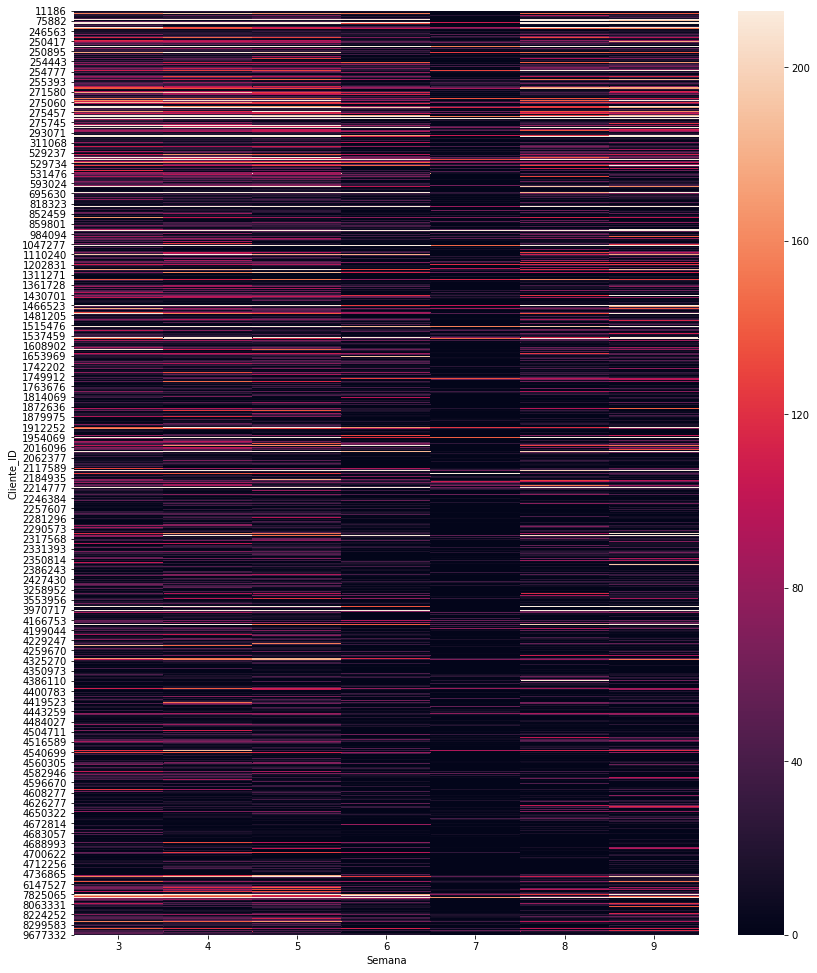

In [111]:
DF_hmap_clients = pd.DataFrame(interq_hmap_clients) #.reset_index()
DF_hmap_clients.sort_values(by=['Semana', 'Demanda_uni_equil'], ascending=False, inplace=True)
DF_hmap_clients

DF_hmap_clients_pivot = DF_hmap_clients.pivot_table(index="Cliente_ID", columns="Semana", values="Demanda_uni_equil", dropna=True, fill_value=0)
DF_hmap_clients_pivot
#DF_hmap_clients

plt.figure(figsize=(14,17))
hmap = sns.heatmap(data=DF_hmap_clients_pivot, robust=True)

In [51]:
#DF_hmap_clients_pivot.loc[4611717]

In [52]:
DF_hmap_clients_pivot.loc[1073788]

Semana
3     0
4     0
5     0
6    86
7     0
8     0
9     0
Name: 1073788, dtype: int64

In [68]:
test_df = DF_hmap_clients.reset_index()
test_df[test_df['Cliente_ID'] == 1073788]

,Agencia_ID,Cliente_ID,Semana,Demanda_uni_equil
428,2020,1073788,6,86


I reckon those zeros are there because that specific client doesn't have demand for products from that specific agency during those few weeks. And this situation is common - agencies don't need to supply clients each week, it seems.

In [55]:
test_client_across_all_agencies = FULL_agencia_for_town[FULL_agencia_for_town['Cliente_ID'] == 1073788].groupby('Semana')['Demanda_uni_equil'].sum()

In [56]:
test_client_across_all_agencies.head()
#artefact_like

Semana
3    143
4    129
5    145
6     86
7     45
Name: Demanda_uni_equil, dtype: int64

In [57]:
DF_test_client = FULL_agencia_for_town[FULL_agencia_for_town['Cliente_ID'] == 1073788]
DF_test_client = DF_test_client.groupby('Producto_ID')['Demanda_uni_equil'].sum().compute()

In [58]:
DF_test_client

Producto_ID
972       8
1064      7
1109     22
1125     32
1129     35
         ..
48421     2
73        1
32322     4
48077     7
1160      1
Name: Demanda_uni_equil, Length: 64, dtype: int64

In [66]:
DF_test_client = FULL_agencia_for_town[FULL_agencia_for_town['Cliente_ID'] == 1073788]

#DF_test_client = DF_test_client.groupby(['Semana', 'Agencia_ID', 'Producto_ID'])['Demanda_uni_equil'].sum().compute()
DF_test_client = DF_test_client.groupby(['Agencia_ID', 'Semana'])['Demanda_uni_equil'].sum().compute()

In [67]:
DF_test_client = DF_test_client.reset_index()
DF_test_client

,Agencia_ID,Semana,Demanda_uni_equil
0,2020,3,143
1,2020,4,129
2,2020,5,145
3,2020,6,86
4,2020,7,45
5,2020,8,104
6,2020,9,80


In [61]:
DF_test_client[DF_test_client['Producto_ID'] == 972]

,Semana,Agencia_ID,Producto_ID,Demanda_uni_equil
0,3,2020,972,2
37,4,2020,972,3
75,5,2020,972,2
167,9,2020,972,1


In [113]:
#DF_hmap_clients = pd.DataFrame(interq_hmap_clients) #.reset_index()
DF_test_client.sort_values(by=['Semana', 'Demanda_uni_equil'], ascending=False, inplace=True)
DF_test_client

DF_test_client_pivot = DF_test_client.pivot_table(index="Producto_ID", columns="Semana", values="Demanda_uni_equil", dropna=True, fill_value=0)
DF_test_client_pivot
#DF_hmap_clients

plt.figure(figsize=(14,7))
hmap = sns.heatmap(data=DF_test_client_pivot, robust=True)

KeyError: 'Producto_ID'

The demand seems very non-stable. I'm done with this challenge tbh. I know how to cheat the metric, don't care about the rest.

In [114]:
DF_test_client = FULL_agencia_for_town[FULL_agencia_for_town['Cliente_ID'] == 1073788]
DF_test_client = DF_test_client.groupby(['Semana', 'Agencia_ID', 'Producto_ID'])['Venta_uni_hoy'].sum().compute()

In [115]:
DF_test_client = DF_test_client.reset_index()
DF_test_client[DF_test_client['Producto_ID'] == 972]

,Semana,Agencia_ID,Producto_ID,Venta_uni_hoy
0,3,2020,972,2
37,4,2020,972,3
75,5,2020,972,2
167,9,2020,972,1


In [116]:
DF_test_client = FULL_agencia_for_town[FULL_agencia_for_town['Cliente_ID'] == 1073788]
DF_test_client = DF_test_client.groupby(['Semana', 'Agencia_ID', 'Producto_ID'])['Dev_uni_proxima'].sum().compute()

In [117]:
DF_test_client = DF_test_client.reset_index()
DF_test_client[DF_test_client['Producto_ID'] == 972]

,Semana,Agencia_ID,Producto_ID,Dev_uni_proxima
0,3,2020,972,0
37,4,2020,972,0
75,5,2020,972,0
167,9,2020,972,0


Now let's create just some dirty cheaty solution by using means/medians for client-product across all the weeks to predict the demand

In [4]:
FULL_Semana_3 = FULL_train[FULL_train['Semana'] == 3]
FULL_Semana_4 = FULL_train[FULL_train['Semana'] == 4]
FULL_Semana_5 = FULL_train[FULL_train['Semana'] == 5]
FULL_Semana_6 = FULL_train[FULL_train['Semana'] == 6]
FULL_Semana_7 = FULL_train[FULL_train['Semana'] == 7]
FULL_Semana_8 = FULL_train[FULL_train['Semana'] == 8]
FULL_Semana_9 = FULL_train[FULL_train['Semana'] == 9]

Create dask DataFrame with average(mean or median) for each client-product, for each client in general and if no(new client + new product), then products in general. 

You can achieve this via merging all the weeks horizontally(drop unnecessary columns first) on clients+products, and then using aggregations on each row (mean or median) via map_partitions+apply for each partition-DataFrame of the Dask-DataFrame

In [28]:
df = pd.DataFrame({'Cliente_ID': [3967, 3967, 3967, 5555, 3967],
                                'Producto_ID': [303, 323, 325, 972, 1064],
                                'Weekly_demand_Client':[3, 2, 2, 1, 6]})
ddf = dd.from_pandas(df, npartitions=2)
ddf.head(npartitions=2)

,Cliente_ID,Producto_ID,Weekly_demand_Client
0,3967,303,3
1,3967,323,2
2,3967,325,2
3,5555,972,1
4,3967,1064,6


In [81]:
def test_f(df, cols):
    #print(df[cols[0]].dtype())
    #print(df[cols[1]].dtype())
    #out = df[cols].mean(axis=1)
    #print(out)
    #print(df[cols])
    #out = pd.Series(df[cols[0]], df[cols[1]]).mean()
    #df[cols[0]] + df[cols[1]]
    
    #put all the shit into return statement otheriwise it
    #doesn't work properly(recursively does each statement several
    #times before proceeding to the ext or i dunno some shit)
    return df.assign(result=df[cols].median(axis=1)) #float(out))

'''
dds_out = ddf.apply(
    test_f, 
    args=('col_1', 'col_2'), 
    axis=1, 
    meta=('result', int)
).compute(get=get)
'''

ddf_out = ddf.map_partitions(test_f, ['Producto_ID', 'Weekly_demand_Client'])
ddf_out.head(npartitions=2)

,Cliente_ID,Producto_ID,Weekly_demand_Client,result
0,3967,303,3,153.0
1,3967,323,2,162.5
2,3967,325,2,163.5
3,5555,972,1,486.5
4,3967,1064,6,535.0


In [91]:
joinX = ddf_out.merge(ddf_out, how='left', on=['Cliente_ID', 'Producto_ID', 'Weekly_demand_Client'], suffixes=('_l', '_r'))
joinX = joinX.rename(columns={'result_l': 'result_1', 'result_r': 'result_2'})

joinX = joinX.merge(ddf_out, how='left', on=['Cliente_ID', 'Producto_ID', 'Weekly_demand_Client'], suffixes=('_l', '_r'))
joinX = joinX.rename(columns={'result': 'result_3'})

joinX = joinX.merge(ddf_out, how='left', on=['Cliente_ID', 'Producto_ID', 'Weekly_demand_Client'], suffixes=('_l', '_r'))
joinX = joinX.rename(columns={'result': 'result_4'})

joinX = joinX.merge(ddf_out, how='left', on=['Cliente_ID', 'Producto_ID', 'Weekly_demand_Client'], suffixes=('_l', '_r'))
joinX = joinX.rename(columns={'result': 'result_5'})
joinX.head()

C:\Users\Alexey\Anaconda3\lib\site-packages\dask\dataframe\core.py:5738: UserWarning: Insufficient elements for `head`. 5 elements requested, only 1 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,Cliente_ID,Producto_ID,Weekly_demand_Client,result_1,result_2,result_3,result_4,result_5
0,3967,325,2,163.5,163.5,163.5,163.5,163.5


In [30]:
df = pd.DataFrame({'Cliente_ID': [3967, 3967, 3967, 5555, 3967, 2],
                                'Producto_ID': [303, 323, 325, 972, 2, 3],
                                'Weekly_demand_Client':[0, 0, 0, 0, 0, 0]})
_ddf = dd.from_pandas(df, npartitions=2)
_ddf.head(npartitions=2)

,Cliente_ID,Producto_ID,Weekly_demand_Client
0,3967,303,0
1,3967,323,0
2,3967,325,0
3,5555,972,0
4,3967,2,0


In [31]:
#join = join[join['Producto_ID'] < 350]
join1 = ddf[ddf['Producto_ID'] < 350].merge(_ddf, how='right', on=['Producto_ID', 'Cliente_ID'], suffixes=('-l', '-r'))
#join = ddf_out.groupby(['Producto_ID', 'Cliente_ID']).join(_ddf.groupby(['Producto_ID', 'Cliente_ID']), on= how='right', rsuffix='new-')
join2 = ddf[ddf['Producto_ID'] > 350].merge(_ddf, how='right', on=['Producto_ID', 'Cliente_ID'], suffixes=('-l', '-r'))

join1 = join1.rename(columns={'Weekly_demand_Client-l': 'Weekly_demand_Client'})
join1.head(npartitions=2)

,Cliente_ID,Producto_ID,Weekly_demand_Client,Weekly_demand_Client-r
0,3967,325,2.0,0
1,5555,972,NaN,0
2,3967,2,NaN,0
0,3967,303,3.0,0
1,3967,323,2.0,0


In [32]:
join2 = join2.rename(columns={'Weekly_demand_Client-l': 'Weekly_demand_Client'})
join2.head(npartitions=2)

,Cliente_ID,Producto_ID,Weekly_demand_Client,Weekly_demand_Client-r
0,5555,972,1.0,0
1,3967,2,NaN,0
2,3967,325,NaN,0
0,2,3,NaN,0
1,3967,303,NaN,0


In [36]:
join3 = join1.merge(join2, how='outer', on=['Producto_ID', 'Cliente_ID', 'Weekly_demand_Client'], suffixes=('-l', '-r'))
#join3 = join3.groupby('Producto_ID').sum(min_count=1)
join3.head(npartitions=1)

,Cliente_ID,Producto_ID,Weekly_demand_Client,Weekly_demand_Client-r-l,Weekly_demand_Client-r-r
0,3967,303,3.0,0.0,NaN
1,3967,323,2.0,0.0,NaN
2,2,3,NaN,0.0,0.0
3,3967,303,NaN,NaN,0.0
4,3967,323,NaN,NaN,0.0


In [125]:
FULL_Semana_3.merge(FULL_Semana_4, how='right', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('-l', '-r'))

,Semana-l,Agencia_ID,Canal_ID-l,Ruta_SAK-l,Cliente_ID,Producto_ID,Venta_uni_hoy-l,Venta_hoy-l,Dev_uni_proxima-l,Dev_proxima-l,Demanda_uni_equil-l,Semana-r,Canal_ID-r,Ruta_SAK-r,Venta_uni_hoy-r,Venta_hoy-r,Dev_uni_proxima-r,Dev_proxima-r,Demanda_uni_equil-r
npartitions=50,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,float64,int64,float64,int64,int64,int64,int64,int64,float64,int64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [22]:
LIGHT_Semana_3 = FULL_Semana_3[['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
LIGHT_Semana_4 = FULL_Semana_4[['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
LIGHT_Semana_5 = FULL_Semana_5[['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
LIGHT_Semana_6 = FULL_Semana_6[['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
LIGHT_Semana_7 = FULL_Semana_7[['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
LIGHT_Semana_8 = FULL_Semana_8[['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
LIGHT_Semana_9 = FULL_Semana_9[['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]

In [23]:
#len(FULL_Semana_3) - len(LIGHT_Semana_3.groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID']).count())
'''len(FULL_Semana_4) - len(LIGHT_Semana_4).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])
len(FULL_Semana_5) - len(LIGHT_Semana_5).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])
len(FULL_Semana_6) - len(LIGHT_Semana_6).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])
len(FULL_Semana_7) - len(LIGHT_Semana_7).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])
len(FULL_Semana_8) - len(LIGHT_Semana_8).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])
len(FULL_Semana_9) - len(LIGHT_Semana_9).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])
'''

"len(FULL_Semana_4) - len(LIGHT_Semana_4).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])\nlen(FULL_Semana_5) - len(LIGHT_Semana_5).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])\nlen(FULL_Semana_6) - len(LIGHT_Semana_6).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])\nlen(FULL_Semana_7) - len(LIGHT_Semana_7).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])\nlen(FULL_Semana_8) - len(LIGHT_Semana_8).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])\nlen(FULL_Semana_9) - len(LIGHT_Semana_9).groupby(['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID'])\n"

In [39]:
LIGHT_client_3 = LIGHT_Semana_3.loc[LIGHT_Semana_3['Cliente_ID'] == 1073788].groupby(['Agencia_ID', 'Cliente_ID', 'Producto_ID'])
LIGHT_client_4 = LIGHT_Semana_4.loc[LIGHT_Semana_4['Cliente_ID'] == 1073788].groupby(['Agencia_ID', 'Cliente_ID', 'Producto_ID'])
LIGHT_client_5 = LIGHT_Semana_5.loc[LIGHT_Semana_5['Cliente_ID'] == 1073788].groupby(['Agencia_ID', 'Cliente_ID', 'Producto_ID'])['Demanda_uni_equil']
LIGHT_client_6 = LIGHT_Semana_6.loc[LIGHT_Semana_6['Cliente_ID'] == 1073788].groupby(['Agencia_ID', 'Cliente_ID', 'Producto_ID'])['Demanda_uni_equil']
LIGHT_client_7 = LIGHT_Semana_7.loc[LIGHT_Semana_7['Cliente_ID'] == 1073788].groupby(['Agencia_ID', 'Cliente_ID', 'Producto_ID'])['Demanda_uni_equil']
LIGHT_client_8 = LIGHT_Semana_8.loc[LIGHT_Semana_8['Cliente_ID'] == 1073788].groupby(['Agencia_ID', 'Cliente_ID', 'Producto_ID'])['Demanda_uni_equil']
LIGHT_client_9 = LIGHT_Semana_9.loc[LIGHT_Semana_9['Cliente_ID'] == 1073788].groupby(['Agencia_ID', 'Cliente_ID', 'Producto_ID'])['Demanda_uni_equil']

In [26]:
train = LIGHT_client_3.merge(LIGHT_client_4, how='outer', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('_3', '_4'))

train = train.merge(LIGHT_client_5, how='outer', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('-l', '+1'))
train = train.merge(LIGHT_client_6, how='outer', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('-l', '+1'))
train = train.merge(LIGHT_client_7, how='outer', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('-l', '+1'))
train = train.merge(LIGHT_client_8, how='outer', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('-l', '+1'))
train = train.merge(LIGHT_client_9, how='outer', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('-l', '+1'))

train

,Agencia_ID,Producto_ID,Cliente_ID,Demanda_uni_equil_3,Demanda_uni_equil_4,Demanda_uni_equil-l,Demanda_uni_equil+1,Demanda_uni_equil-l,Demanda_uni_equil+1,Demanda_uni_equil
npartitions=50,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [43]:
#train = LIGHT_client_3.join(LIGHT_Semana_4)

The final model + framework:

In [10]:
TRAIN_Semana_3 = FULL_train.loc[FULL_train['Semana'] == 3, ['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
TRAIN_Semana_4 = FULL_train.loc[FULL_train['Semana'] == 4, ['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
TRAIN_Semana_5 = FULL_train.loc[FULL_train['Semana'] == 5, ['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
TRAIN_Semana_6 = FULL_train.loc[FULL_train['Semana'] == 6, ['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
TRAIN_Semana_7 = FULL_train.loc[FULL_train['Semana'] == 7, ['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
TRAIN_Semana_8 = FULL_train.loc[FULL_train['Semana'] == 8, ['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]
TRAIN_Semana_9 = FULL_train.loc[FULL_train['Semana'] == 9, ['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil']]

In [11]:
TRAIN_Semana_3

,Agencia_ID,Producto_ID,Cliente_ID,Demanda_uni_equil
npartitions=50,,,,
,int64,int64,int64,int64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [22]:
TEST_Semana_10 = FULL_test.loc[FULL_test['Semana'] == 10, ['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Semana']]
TEST_Semana_11 = FULL_test.loc[FULL_test['Semana'] == 11, ['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Semana']]

In [13]:
TEST_Semana_10 #we shall do merge of the predictions back into original testset basen on these columns

,Agencia_ID,Producto_ID,Cliente_ID,Semana
npartitions=4,,,,
,int64,int64,int64,int64
,...,...,...,...
,...,...,...,...
,...,...,...,...
,...,...,...,...


In [15]:
PRED_Semana_10 = TEST_Semana_10.merge(TRAIN_Semana_3, how='left', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('_1', '+1') )
PRED_Semana_10 = PRED_Semana_10.rename(columns={'Demanda_uni_equil': 'D_3'})

PRED_Semana_10 = PRED_Semana_10.merge(TRAIN_Semana_4, how='left', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('_1', '+1') )
PRED_Semana_10 = PRED_Semana_10.rename(columns={'Demanda_uni_equil': 'D_4'})

PRED_Semana_10 = PRED_Semana_10.merge(TRAIN_Semana_5, how='left', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('_1', '+1') )
PRED_Semana_10 = PRED_Semana_10.rename(columns={'Demanda_uni_equil': 'D_5'})

PRED_Semana_10 = PRED_Semana_10.merge(TRAIN_Semana_6, how='left', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('_1', '+1') )
PRED_Semana_10 = PRED_Semana_10.rename(columns={'Demanda_uni_equil': 'D_6'})

PRED_Semana_10 = PRED_Semana_10.merge(TRAIN_Semana_7, how='left', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('_1', '+1') )
PRED_Semana_10 = PRED_Semana_10.rename(columns={'Demanda_uni_equil': 'D_7'})

PRED_Semana_10 = PRED_Semana_10.merge(TRAIN_Semana_8, how='left', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('_1', '+1') )
PRED_Semana_10 = PRED_Semana_10.rename(columns={'Demanda_uni_equil': 'D_8'})

PRED_Semana_10 = PRED_Semana_10.merge(TRAIN_Semana_9, how='left', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID'], suffixes=('_1', '+1') )
PRED_Semana_10 = PRED_Semana_10.rename(columns={'Demanda_uni_equil': 'D_9'})

PRED_Semana_10

,Agencia_ID,Producto_ID,Cliente_ID,Semana,D_3,D_4,D_5,D_6,D_7,D_8,D_9
npartitions=50,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [16]:
def predict(df, cols):
    
    #put all the shit into return statement otheriwise it
    #doesn't work properly(recursively does each statement several
    #times before proceeding to the ext or i dunno some shit)
    return df.assign(D_10=df[cols].median(axis=1))


cols = ['D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9']
PRED_Semana_10_DONE = PRED_Semana_10.map_partitions(predict, cols)
PRED_Semana_10_DONE

,Agencia_ID,Producto_ID,Cliente_ID,Semana,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10
npartitions=50,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [17]:
from copy import copy

PRED_Semana_11 = copy(PRED_Semana_10_DONE)
PRED_Semana_11

,Agencia_ID,Producto_ID,Cliente_ID,Semana,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10
npartitions=50,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [19]:
#copy the function from above because need to think how to standardize the output column label later
def predict(df, cols):
    
    #put all the shit into return statement otheriwise it
    #doesn't work properly(recursively does each statement several
    #times before proceeding to the ext or i dunno some shit)
    return df.assign(D_11=df[cols].median(axis=1))

cols = ['D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9', 'D_10']
PRED_Semana_11_DONE = PRED_Semana_11.map_partitions(predict, cols)
PRED_Semana_11_DONE

,Agencia_ID,Producto_ID,Cliente_ID,Semana,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10,D_11
npartitions=50,,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [33]:
CUT_PRED_Semana_10_DONE = PRED_Semana_10_DONE[['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Semana', 'D_10']]
CUT_PRED_Semana_10_DONE = CUT_PRED_Semana_10_DONE.rename(columns={'D_10': 'Demanda_uni_equil'})

CUT_PRED_Semana_11_DONE = PRED_Semana_11_DONE[['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Semana', 'D_11']]
CUT_PRED_Semana_11_DONE = CUT_PRED_Semana_11_DONE.rename(columns={'D_11': 'Demanda_uni_equil'})

FINAL_CUT_PRED = CUT_PRED_Semana_10_DONE.append(CUT_PRED_Semana_11_DONE)
                                              
FULL_pred = FULL_test.merge(FINAL_CUT_PRED, how='left', on=['Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Semana'], suffixes=('_1', '+1') )

FULL_pred

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
npartitions=100,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [42]:
FINAL_pred = FULL_pred[['id', 'Demanda_uni_equil']]
FINAL_pred

,id,Demanda_uni_equil
npartitions=100,,
,int64,float64
,...,...
...,...,...
,...,...
,...,...


In [11]:
#mport dask
#dask.config.set(scheduler='threads')

#import dask.multiprocessing
#dask.config.set(scheduler='processes') 

In [ ]:
#PRED_Semana_10_DONE.head(npartitions=1) #invoke the devil
#PRED_Semana_10_DONE.to_csv('../#Data/semana_10_*.csv')  

This is the it, i can't manage this computation yet(although i've tried different settings from above). 
But here i've made a framework for seting up pretty much any model to predict the weekly demand for each individual Agencia-Client-Product chain based on individual data from the previous weeks. 

Computation of each individual row is done via function:predict, which operates on each partition(Pandas DataFrame) of a Dask Dataframe as a callback to .map_partitions, as recommended by Dask documentation